<div id="toc"></div>

In [77]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Goal

The goal of this work is to create methods in `bicorr.py` that will enable the following capabilities in analyzing `bicorr_hist_master`.

Issues:  
1) Change the time bins to be more coarse  
2) Normalizing the counts in each bin so that the magnitude in each bin is approximately the same regardless of the time bin width

Start by importing relevant packages and some data.

In [2]:
import numpy as np
import scipy.io as sio
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors
import inspect

In [3]:
# Load the bicorr.py functions I have already developed
sys.path.append('../scripts')

import bicorr as bicorr

In [4]:
%load_ext autoreload
%autoreload 2

Import data from the following folder:

In [5]:
os.listdir('../analysis/Cf072115_to_Cf072215b/')

['.ipynb_checkpoints',
 'analysis.pptx',
 'analysis_bicorr_plots_gifs.html',
 'analysis_bicorr_plots_gifs.ipynb',
 'analysis_counts_v_angle.ipynb',
 'analysis_experimental_setup_figs.html',
 'analysis_experimental_setup_figs.ipynb',
 'analysis_latex',
 'analysis_singles_counts.ipynb',
 'bhp_all_gif.npz',
 'bhp_nn_gif.npz',
 'datap',
 'fig',
 'flux_run_notes.pptx',
 'singles_hist.npz',
 'sparse_bhm.npz',
 'sparse_bhm_neg.npz']

In [6]:
sparse_bhm, dt_bin_edges, note = bicorr.load_sparse_bhm(r'../analysis/Cf072115_to_Cf072215b/')

In [7]:
det_df = bicorr.load_det_df('../meas_info/det_df_pairs_angles.csv')

I'm going to work with the positive `bhm` only and not perform a background subtraction.

In [8]:
bhm = bicorr.revive_sparse_bhm(sparse_bhm, det_df, dt_bin_edges)

Save the `bicorr_hist_plot` for coarsening later.

In [15]:
bhp = bicorr.build_bhp(bhm, dt_bin_edges, print_flag=True)[0]

Creating bicorr_hist_plot for...
pair_is =  all
type_is =  all
time bin width (ns) =  0.25
length of pair_is =  990
norm_factor =  1


# Issue 1: Make time binning more coarse on `bhm`

In some instances, there are not enough counts in each histogram to see smooth features, and therefore it is beneficial to make the time bins more coarse (change the time bin width from 0.25 ns to 1 ns, for example).

Here I will write a function that performs that task based on a specified factor $C$ by which to coarsen the time bin width. If a histogram with time bin width 0.25 ns is coarsend by a factor $C=4$, then the resulting histogram will have time bin widths of $0.25*4$ ns $= 1$ ns.

## Generate coarse matrix

What is the shape and bin width of the original matrix?

In [16]:
shape = bhm.shape
print('Dimensions of bicorr_hist_master: ', bhm.shape)

dt_bin_width = dt_bin_edges[1]-dt_bin_edges[0]
print('Width of time bin in (ns): ', dt_bin_width)

Dimensions of bicorr_hist_master:  (990, 4, 800, 800)
Width of time bin in (ns):  0.25


What will be the shape of the final matrix?

In [18]:
C = 4

# Preallocate coarse matrix
bhm_coarse = np.zeros((shape[0],shape[1],int(shape[2]/C),int(shape[3]/C)))

# Calculate new dt_bin_edges
dt_bin_edges_coarse = dt_bin_edges[0::C]
dt_bin_width_coarse = dt_bin_edges_coarse[1]-dt_bin_edges_coarse[0]

print('Dimensions of bicorr_hist_master_coarse: ', bhm_coarse.shape)
print('Width of coarse time bin in (ns): ', dt_bin_width_coarse)

Dimensions of bicorr_hist_master_coarse:  (990, 4, 200, 200)
Width of coarse time bin in (ns):  1.0


To fill the histogram, I need to sum over a range of values in `bicorr_hist_master`. If the coarsening factor is $C=4$, then the corresponding bin indices are:

Index in `bicorr_hist_master_coarse` --> Indices in `bicorr_hist_master`...  

0 --> (0-3)  
1 --> (4-7)  
2 --> (8-11 )  
3 --> (12-15)  
4 --> (16-19)  

But in python, to select data at indices $0-3$, for instance, you must use the index range `[0:4]`, so the indices that you call will be even simpler.

For an index $i$ in `bicorr_hist_master_coarse`, the corresponding starting and ending bin indices in `bicorr_hist_master` given factor $C$ are:

Starting index: `C*i`  
Final index:    `C*(i+1)`  

Loop through all of the bins in `bicorr_hist_master_coarse` and fill them by summing the corresponding bins in `bicorr_hist_master`:

In [20]:
for bin1 in np.arange(0,bhm_coarse.shape[2]):
    for bin2 in np.arange(0,bhm_coarse.shape[3]):
        bhm_coarse[:,:,bin1,bin2] = np.sum(bhm[:,:,C*bin1:C*(bin1+1),C*bin2:C*(bin2+1)],axis=(2,3))

## Plot original and coarse matrices

Plot the two distributions to compare them. Start with all events across all detectors.

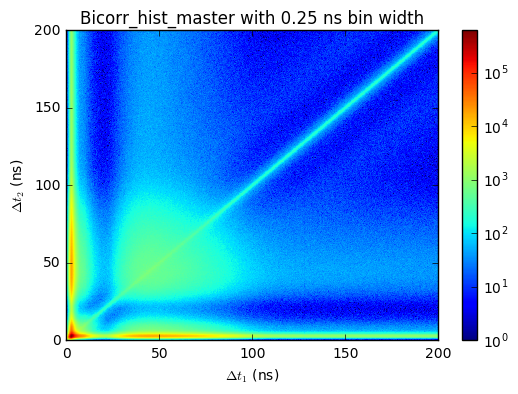

In [23]:
plt.pcolormesh(dt_bin_edges, dt_bin_edges, np.sum(bhm,axis=(0,1)), norm = matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('Bicorr_hist_master with 0.25 ns bin width')
plt.colorbar()
plt.show()

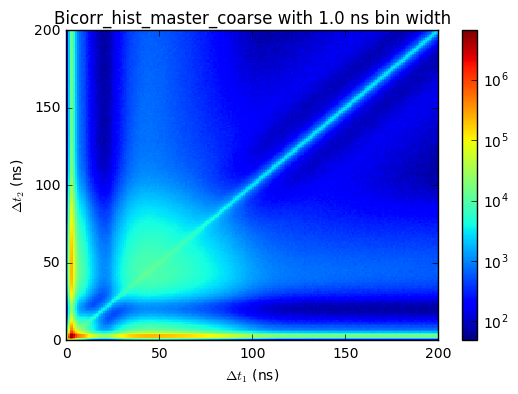

In [24]:
plt.pcolormesh(dt_bin_edges_coarse, dt_bin_edges_coarse, np.sum(bhm_coarse,axis=(0,1)), norm = matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('Bicorr_hist_master_coarse with 1.0 ns bin width')
plt.colorbar()
plt.show()

## Functionalize it

In [25]:
print(inspect.getsource(bicorr.coarsen_bhm))

def coarsen_bhm(bicorr_hist_master,dt_bin_edges,C):
    """
    Make the time binning on bicorr_hist_master more coarse by a constant factor.
    
    Parameters
    ----------
    bicorr_hist_master : ndarray
    dt_bin_edges : ndarray
    C : int    
    
    Return
    ------
    bicorr_hist_master_coarse : ndarray
    dt_bin_edges_coarse : ndarray
    """
    shape = bicorr_hist_master.shape
    print('Dimensions of bicorr_hist_master: ', bicorr_hist_master.shape)
    bicorr_hist_master_coarse = np.zeros((shape[0],shape[1],int(shape[2]/C),int(shape[3]/C)))

    print('Width of time bin in (ns): ', dt_bin_edges[1]-dt_bin_edges[0])
    
    print('Condensing bicorr_hist_master from shape ', shape, ' to ', bicorr_hist_master_coarse.shape)
    
    for bin1 in np.arange(0,bicorr_hist_master_coarse.shape[2]):
        for bin2 in np.arange(0,bicorr_hist_master_coarse.shape[3]):
            bicorr_hist_master_coarse[:,:,bin1,bin2] = np.sum(bicorr_hist_master[:,:,C*bin1:C*(bin1+1),C*bin2:C

Try it out- make an even coarser matrix with 4 ns bins.

In [26]:
bhm_4ns, dt_bin_edges_4ns = bicorr.coarsen_bhm(bhm,dt_bin_edges,16)

Dimensions of bicorr_hist_master:  (990, 4, 800, 800)
Width of time bin in (ns):  0.25
Condensing bhm from shape  (990, 4, 800, 800)  to  (990, 4, 50, 50)


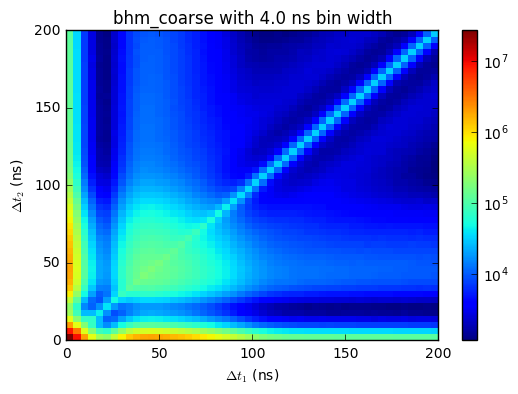

In [27]:
plt.pcolormesh(dt_bin_edges_4ns, dt_bin_edges_4ns, np.sum(bhm_4ns,axis=(0,1)), norm = matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('bhm_coarse with 4.0 ns bin width')
plt.colorbar()
plt.show()

# Issue 2: Make time binning more coarse on `bhp`

In some cases I will already have `bhp` constructed, and I want to coarsen that instead of starting from `bhm`. Follow the same steps. 

## Generate `bhp_coarse`

In [28]:
shape = bhp.shape
print('Dimensions of bicorr_hist_plot: ', bhp.shape)

dt_bin_width = dt_bin_edges[1]-dt_bin_edges[0]
print('Width of time bin in (ns): ', dt_bin_width)

Dimensions of bicorr_hist_plot:  (800, 800)
Width of time bin in (ns):  0.25


In [29]:
C = 4

# Preallocate coarse matrix
bhp_coarse = np.zeros((int(shape[0]/C),int(shape[1]/C)))

# Calculate new dt_bin_edges
dt_bin_edges_coarse = dt_bin_edges[0::C]
dt_bin_width_coarse = dt_bin_edges_coarse[1]-dt_bin_edges_coarse[0]

print('Dimensions of bicorr_hist_plot_coarse: ', bhp_coarse.shape)
print('Width of coarse time bin in (ns): ', dt_bin_width_coarse)

Dimensions of bicorr_hist_plot_coarse:  (200, 200)
Width of coarse time bin in (ns):  1.0


In [30]:
for bin1 in np.arange(0,bhp_coarse.shape[0]):
    for bin2 in np.arange(0,bhp_coarse.shape[1]):
        bhp_coarse[bin1,bin2] = np.sum(bhp[C*bin1:C*(bin1+1),C*bin2:C*(bin2+1)],axis=(0,1))

## Plot original and coarse `bhp`

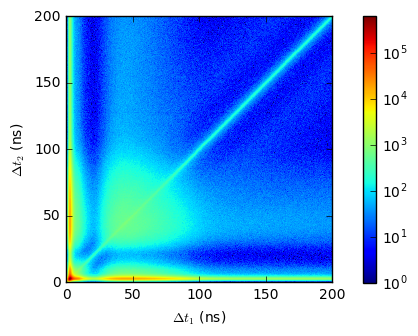

In [33]:
bicorr.bicorr_plot(bhp, dt_bin_edges, show_flag = True)

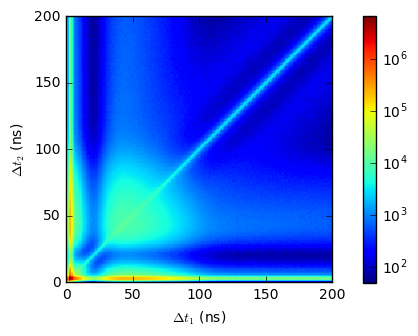

In [34]:
bicorr.bicorr_plot(bhp_coarse, dt_bin_edges_coarse, show_flag = True)

## Functionalize it

In [36]:
print(inspect.getsource(bicorr.coarsen_bhp))

def coarsen_bhp(bhp, dt_bin_edges, C, print_flag = False):
    """
    Make the time binning on bicorr_hist_plot more coarse by a constant factor.
    
    Parameters
    ----------
    bhp : ndarray
        bicorr_hist_plot. Two-dimensional with axes sizes corresponding to dt_bin_edges x dt_bin_edges.
    dt_bin_edges : ndarray
        Time bin edges for bhp
    C : int
        Coarsening factor
    print_flag : bool
        Option to print status updates
        
    Returns
    -------
    bhp_coarse : ndarray
        bicorr_hist_plot_coarse. bhp scaled by C in time bins.
    dt_bin_edges_coarse : ndarray
        Time bin edges for bhp_coarse
    """
    shape = bhp.shape
    if print_flag: print('Dimensions of bicorr_hist_plot: ', bhp.shape)

    dt_bin_width = dt_bin_edges[1]-dt_bin_edges[0]
    if print_flag: print('Width of time bin in (ns): ', dt_bin_width)
    
    # Preallocate coarse matrix
    bhp_coarse = np.zeros((int(shape[0]/C),int(shape[1]/C)))

    # Calculate new dt_

## Plot it directly

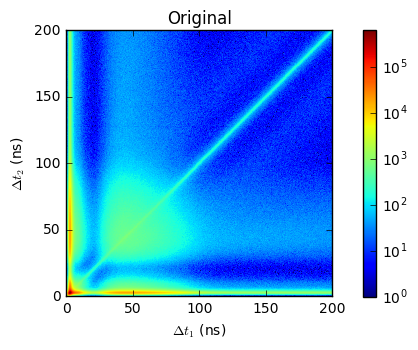

In [41]:
bicorr.bicorr_plot(bhp,dt_bin_edges,show_flag = True, title='Original')

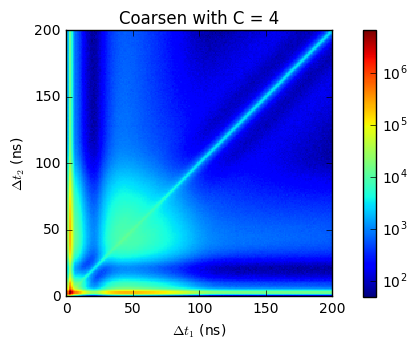

In [42]:
bicorr.bicorr_plot(bicorr.coarsen_bhp(bhp,dt_bin_edges,4)[0],
                   bicorr.coarsen_bhp(bhp,dt_bin_edges,4)[1],
                   show_flag = True, title='Coarsen with C = 4')

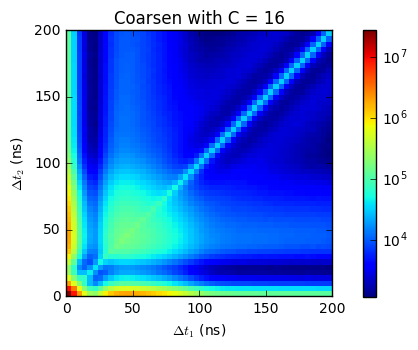

In [43]:
bicorr.bicorr_plot(bicorr.coarsen_bhp(bhp,dt_bin_edges,16)[0],
                   bicorr.coarsen_bhp(bhp,dt_bin_edges,16)[1],
                   show_flag = True, title='Coarsen with C = 16')

# Issue 3: Normalize the counts

When looking at these distributions in terms of number of counts, there are several issues that make it difficult to make comparisons between plots. These include the following points:

* With finer time bin width, there are fewer counts per bin. You will notice above that the scale on the color bar starts at over $10^4$ for 0.25 ns bins, goes above $10^5$ for 1 ns bins, and then above $10^6$ for 4 ns bins. This makes sense because the number of counts in each bin is increasing roughly with $C^2$ as the counts over a range of bins are combined. 
* So far in this analysis we have only generated plots for all detector pairs, but later we will generate this histogram for subsets of detector pairs based on the angle between detectors. Thus, a subset with fewer detector pairs would have fewer counts in each bin than a subset with more detector pairs.
* Also, some of the measurements were taken for longer measurement times, so that there are more fission events in the measurement, and therefore we would expect more counts.
* Finally, we will eventually compare these bicorrelation plots between measurement and simulation, so we need units that can be fairly compared between the two. 

To deal with this, we will normalize the number of counts in each bin of the histogram to the following things:

* Number of fission events
* Number of detector pairs
* Area of pixel in time-squared units

## Units 

These values will change for each measurement, but the information related to the number of fissions that I have is:

* fission rate in [fissions/s]
* measurement length in [s]

I can multiply these together to get the total number of fissions during the time of the measurement. Working with values from the `Cf072115-Cf072215b` measurement...

In [44]:
fission_rate = 2.9498e+05 # fissions/s
meas_length = 7440 # sec
num_fissions = fission_rate * meas_length
print(num_fissions)

2194651200.0


For the number of detector pairs, I can take the length of the array `pair_is` that I pass into `bicorr.build_bicorr_hist_plot`. `pair_is` contains an array of the indices of the selected detector pairs in `bicorr_hist_master`. 

In [48]:
pair_is = det_df.index.values

Lastly, we need to calculate the size of the bin width in two-dimensional space. For example, the data in a bin of size 0.25 ns x 0.25 ns should be inflated by a factor of 16 (or divided by 1/16) in order to be compared to the data in a bin of size 1 ns x 1 ns.

In [51]:
# Determine the time-binning
time_bin_width = dt_bin_edges[1]-dt_bin_edges[0]
time_norm_factor = np.power(time_bin_width,2) # Units of ns^2
print(time_bin_width, time_norm_factor)

0.25 0.0625


## Calculate the normalization factor

Ultimately, the normalization factor is the product of these four values.

In [52]:
norm_factor = num_fissions * len(pair_is) * time_norm_factor
print(norm_factor)

135794043000.0


Try it now for the coarser bin widths and see if the two norm_factors differ by a factor of 16.

In [53]:
time_bin_width_coarse = dt_bin_edges_coarse[1]-dt_bin_edges_coarse[0]
time_norm_factor_coarse = np.power(time_bin_width_coarse,2) # Units of ns^2
print(time_bin_width_coarse, time_norm_factor_coarse)

1.0 1.0


In [54]:
norm_factor_coarse = num_fissions * len(pair_is) * time_norm_factor_coarse
print(norm_factor_coarse)

2.172704688e+12


In [55]:
print(norm_factor_coarse / norm_factor)

16.0


In [56]:
C**2

16

Does this add up? The number of counts will be divided by the normalization factor. The coarser measurements should be divided by a greater value, therefore `norm_factor_coarse > norm_factor`. So it checks out.

## Compare normal and coarse plots after normalization

The colorbar scale on the two plots should be the same after normalization for any time bin width.

To normalize, divide the `bicorr_hist_plot` (summed `bicorr_hist_matrix`) matrix by `norm_factor`.

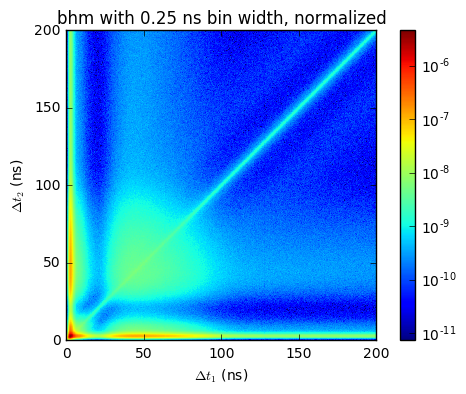

In [60]:
plt.pcolormesh(dt_bin_edges, dt_bin_edges, np.divide(np.sum(bhm,axis=(0,1)),norm_factor), norm = matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('bhm with 0.25 ns bin width, normalized')
plt.axes().set_aspect('equal')
plt.colorbar()
plt.show()

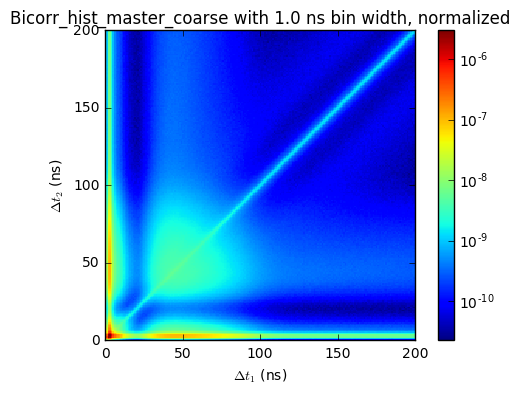

In [61]:
plt.pcolormesh(dt_bin_edges_coarse, dt_bin_edges_coarse, np.divide(np.sum(bhm_coarse,axis=(0,1)),norm_factor_coarse), norm = matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('Bicorr_hist_master_coarse with 1.0 ns bin width, normalized')
plt.axes().set_aspect('equal')
plt.colorbar()
plt.show()

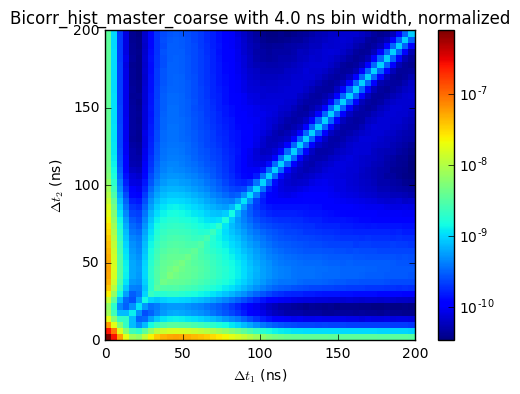

In [65]:
time_bin_width_4ns = dt_bin_edges_4ns[1]-dt_bin_edges_4ns[0]
time_norm_factor_4ns = np.power(time_bin_width_4ns,2) # Units of ns^2
norm_factor_4ns = num_fissions * len(pair_is) * time_norm_factor_4ns

plt.pcolormesh(dt_bin_edges_4ns, dt_bin_edges_4ns, np.divide(np.sum(bhm_4ns,axis=(0,1)),norm_factor_4ns), norm = matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('Bicorr_hist_master_coarse with 4.0 ns bin width, normalized')
plt.axes().set_aspect('equal')
plt.colorbar()
plt.show()

The 4 ns range is lower than the other two ranges. Why? This plot will have more data in each bin, but will be less susceptible to small fluctuations. For example, if there is a localized peak in the finer mesh plot, the average of those counts is lower, and the coarsened distribution will be representative of the average. 

## Confirm accuracy of normalization with variable `pair_is` and `type_is`

Change the number of detector pairs in each plot and verify that the normalization accounts for that. Work with the data binned to 1 ns time bins.

In [66]:
time_bin_width_coarse = dt_bin_edges_coarse[1]-dt_bin_edges_coarse[0]
time_norm_factor_coarse = np.power(time_bin_width_coarse,2) # Units of ns^2
print(time_bin_width_coarse, time_norm_factor_coarse)

1.0 1.0


Start with all events and detector pairs for reference

In [68]:
pair_is = det_df.index.values

norm_factor_coarse = num_fissions * len(pair_is) * time_norm_factor_coarse
print(norm_factor_coarse)

2.172704688e+12


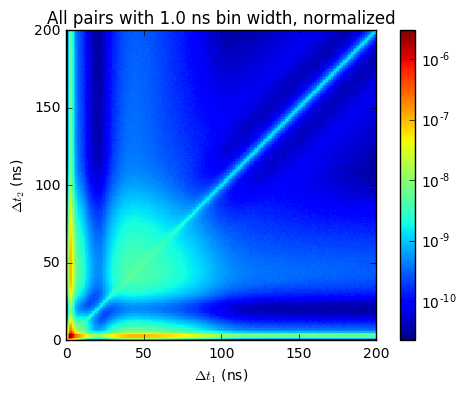

In [70]:
plt.pcolormesh(dt_bin_edges_coarse, dt_bin_edges_coarse, np.divide(np.sum(bhm_coarse,axis=(0,1)),norm_factor_coarse), norm=matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('All pairs with 1.0 ns bin width, normalized')
plt.axes().set_aspect('equal')
plt.colorbar()
plt.show()

Look at all event types on a small number of detector pairs.

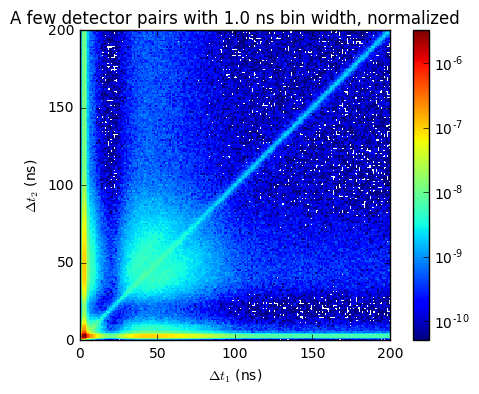

In [72]:
# General plot
pair_is = [0,1,2,3,4,5,6,7,8] # a few pairs
type_is = [0,1,2,3] # all event types

# Calculate norm_factor_coarse
norm_factor_coarse = num_fissions * len(pair_is) * time_norm_factor_coarse

plt.pcolormesh(dt_bin_edges_coarse, dt_bin_edges_coarse, 
               np.divide(np.sum(bhm_coarse[pair_is,:,:,:][:,type_is,:,:],axis=(0,1)),norm_factor_coarse),
               norm=matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('A few detector pairs with 1.0 ns bin width, normalized')
plt.axes().set_aspect('equal')
plt.colorbar()
plt.show()

The range looks good. Now look at only a few interaction types.

Look at gamma-gamma interactions only. These are the interactions that set the range, so the colorbar range should be the same.

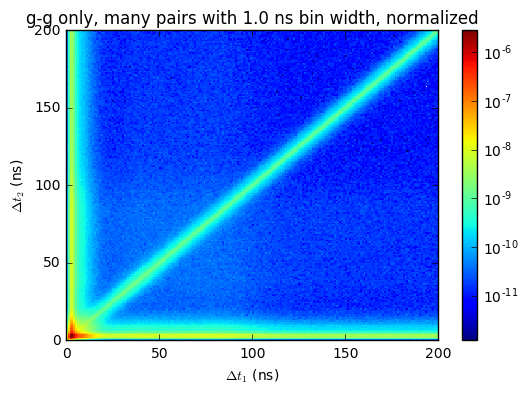

In [74]:
# General plot
pair_is = det_df.index.values[30:400] # many pairs
type_is = [3] # gamma-gamma only

# Calculate norm_factor_coarse
norm_factor_coarse = num_fissions * len(pair_is) * time_norm_factor_coarse

plt.pcolormesh(dt_bin_edges_coarse, dt_bin_edges_coarse, 
               np.divide(np.sum(bhm_coarse[pair_is,:,:,:][:,type_is,:,:],axis=(0,1)),norm_factor_coarse),
               norm=matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('g-g only, many pairs with 1.0 ns bin width, normalized')
plt.colorbar()
plt.show()

Look at n-n events only on a few detectors.

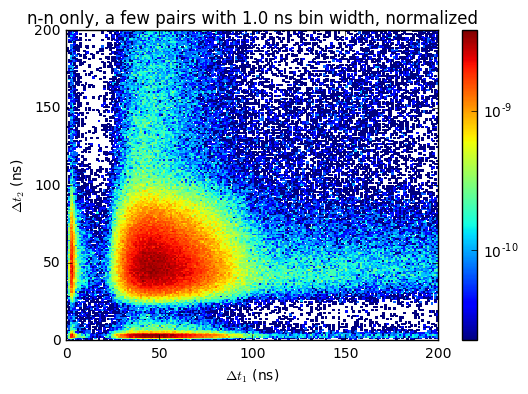

In [76]:
# General plot
pair_is = det_df.index.values[600:620] # twenty pairs
type_is = [0] # neutron-neutron only

# Calculate norm_factor_coarse
norm_factor_coarse = num_fissions * len(pair_is) * time_norm_factor_coarse

plt.pcolormesh(dt_bin_edges_coarse, dt_bin_edges_coarse, 
               np.divide(np.sum(bhm_coarse[pair_is,:,:,:][:,type_is,:,:],axis=(0,1)),norm_factor_coarse),
               norm=matplotlib.colors.LogNorm())
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('n-n only, a few pairs with 1.0 ns bin width, normalized')
plt.colorbar()
plt.show()

The range of the colorbar on this last plot is much narrower than the preceeding plots because I am only looking at n-n events, whose distribution is much flatter. Regardless, the range of this plot roughly matches the range of the n-n features in the other plots, so we conclude that the normalization is correct.

## Functionalize normalization

I need to automatically calculate the normalization factor of the `bhp` distribution based on `pair_is`, `type_is`, `dt_bin_edges`, and `num_fissions`.

I'm going to include this in `bicorr.build_bhp`. If `num_fissions` is provided, perform the normalization. If not provided, then skip it and keep it in terms of absolute numbers. 

The code looks like this:

    # If normalizing, calculate normalization factor
    if num_fissions is None:
        norm_factor = 1 # No normalization
    else:               # Normalize by number fissions, detector pairs, and time bin size
        norm_factor = num_fissions * len(pair_is) * np.power((dt_bin_edges[1]-dt_bin_edges[0]),2)